<a href="https://colab.research.google.com/github/ThousandAI/Application-of-AI/blob/main/class04/class04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolution**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "./drive/MyDrive/Colab-Notebooks/Application-of-AI/class04/cat.jpg"

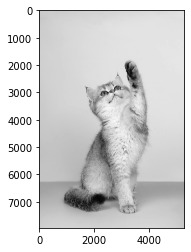

In [4]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap = 'gray')
plt.show()

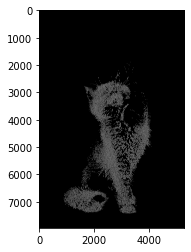

In [5]:
canny = cv2.Canny(img, 20, 100)
plt.imshow(canny, cmap = 'gray')
plt.show()

## CNN Model

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
BATCH_SIZE = 64
num_classes = 10
epochs = 10
learning_rate = 1e-4 # 0.0001

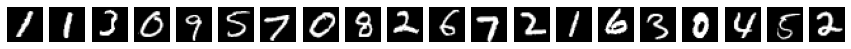

In [8]:
# Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle = False)
iterator = iter(train_loader)
images, labels = next(iterator)
fig, axes = plt.subplots(1,20, figsize=(15, 15))
for i in range(20):
  axes[i].imshow(images[i][0], cmap = 'gray')
  axes[i].set_axis_off()
fig.show()

In [9]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # 16x28x28
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1) # 16x28x28
    self.pool1 = nn.MaxPool2d(2,2) # 16x14x14
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x14x14
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x14x14
    self.pool2 = nn.MaxPool2d(2,2) # 32x7x7
    self.fc1 = nn.Linear(32*7*7,128)
    self.fc2 = nn.Linear(128,10)
   
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool2(x)
    x = x.view(-1,32*7*7)
    x = F.relu(self.fc1(x))
    output = self.fc2(x)
    return output

In [10]:
cnn = ConvNet().to(device)
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [12]:
total_steps = len(train_loader)
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print (f'Epoch {epoch+1}, Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch 1, Step [100/938], Loss: 1.7610
Epoch 1, Step [200/938], Loss: 0.7497
Epoch 1, Step [300/938], Loss: 0.5414
Epoch 1, Step [400/938], Loss: 0.2416
Epoch 1, Step [500/938], Loss: 0.5196
Epoch 1, Step [600/938], Loss: 0.3037
Epoch 1, Step [700/938], Loss: 0.1299
Epoch 1, Step [800/938], Loss: 0.2054
Epoch 1, Step [900/938], Loss: 0.3279
Epoch 2, Step [100/938], Loss: 0.1165
Epoch 2, Step [200/938], Loss: 0.0921
Epoch 2, Step [300/938], Loss: 0.1536
Epoch 2, Step [400/938], Loss: 0.1113
Epoch 2, Step [500/938], Loss: 0.3032
Epoch 2, Step [600/938], Loss: 0.1039
Epoch 2, Step [700/938], Loss: 0.1204
Epoch 2, Step [800/938], Loss: 0.1599
Epoch 2, Step [900/938], Loss: 0.1317
Epoch 3, Step [100/938], Loss: 0.1549
Epoch 3, Step [200/938], Loss: 0.0407
Epoch 3, Step [300/938], Loss: 0.1506
Epoch 3, Step [400/938], Loss: 0.0757
Epoch 3, Step [500/938], Loss: 0.1870
Epoch 3, Step [600/938], Loss: 0.1194
Epoch 3, Step [700/938], Loss: 0.0246
Epoch 3, Step [800/938], Loss: 0.0985
Epoch 3, Ste

In [13]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = cnn(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 98.89 %


## Parameters

In [14]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
class Net(nn.Module):
  def __init__(self, input_size, h1, h2, num_classes):
    super().__init__()
    self.f1 = nn.Linear(input_size, h1)
    self.f2 = nn.Linear(h1, h2)
    self.f3 = nn.Linear(h2, num_classes)

  def forward(self, x):
    x = F.relu(self.f1(x))
    x = F.relu(self.f2(x))
    out = self.f3(x)
    return out

In [16]:
input_size = 784
h1 = 256
h2 = 128
net = Net(input_size=input_size, h1=h1, h2=h2, num_classes=num_classes).to(device) # GPU

In [17]:
[p.numel() for p in net.parameters() if p.requires_grad]

[200704, 256, 32768, 128, 1280, 10]

In [18]:
[p.numel() for p in cnn.parameters() if p.requires_grad]

[144, 16, 2304, 16, 4608, 32, 9216, 32, 200704, 128, 1280, 10]

In [19]:
count_parameters(net)

235146

In [20]:
count_parameters(cnn)

218490